In [1]:
# from orbit_generation.convergence import differential_correction

In [2]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.constants import EM_MU

In [3]:
import numpy as np
import os
import pandas as pd

In [4]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [5]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, f'exp{experiment_id}_corrected_initial_conditions.npy')
refined_data_file = os.path.join(experiment_folder, f'exp{experiment_id}_propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

In [6]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
synthetic_orbit_df = pd.DataFrame(initial_conditions, columns=columns)


In [ ]:
generated_orbits = np.load(generated_data_path)
generated_orbits.shape

(100, 300, 7)

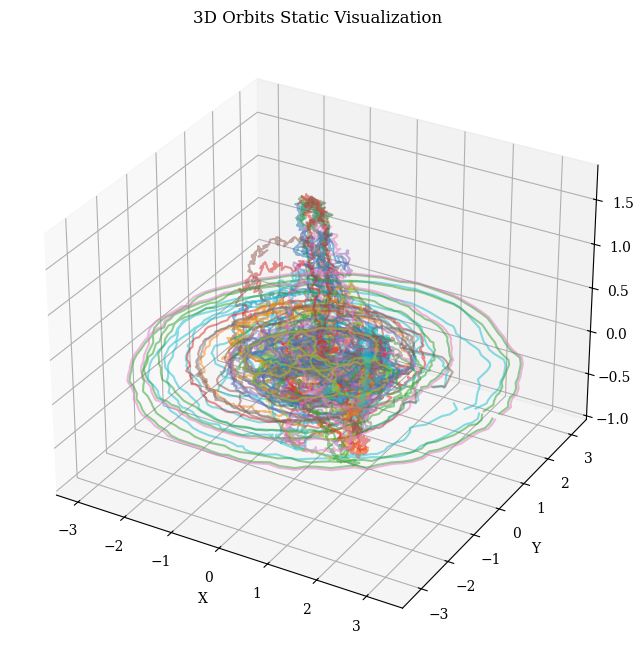

In [8]:
visualize_static_orbits(np.transpose(generated_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

In [9]:
refined_orbits = np.load(refined_data_file)
refined_orbits.shape

(51, 300, 7)

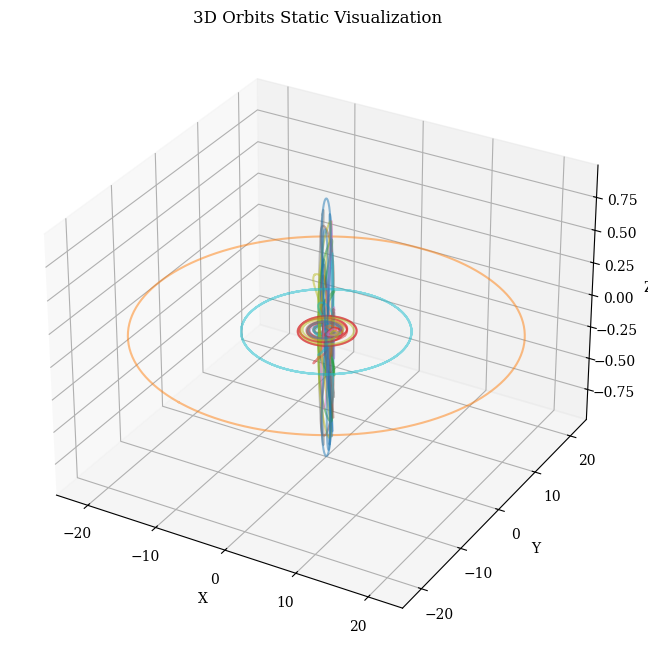

In [10]:
visualize_static_orbits(np.transpose(refined_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

# reshape and take 15n steps


In [11]:
def subsample_orbit(orbit_array, i, start_idx=30, step=15, end_idx=300):
    # Extract the time vector and state vector for the i-th orbit
    t_vec_old_i_pre = orbit_array[i,:,1]
    X_old_i_pre = (orbit_array[i,:,2:7]).flatten()

    # Subsample the time and state vectors
    t_vec_old_i_post = [t_vec_old_i_pre[1]] + list(t_vec_old_i_pre[start_idx:end_idx:step])
    X_old_i_post = [X_old_i_pre[1]] + list(X_old_i_pre[start_idx:end_idx:step])

    return np.array(t_vec_old_i_post), np.array(X_old_i_post)


In [12]:
def process_orbits(orbit_array, μ, start_idx=30, step=15, end_idx=300, 
                   variable_time=True, tol=1e-9, max_iter=20, 
                   printout=False):
    # List to store results
    converged_orbits = []
    failed_orbits = []
    
    # Loop over each orbit
    for i in range(orbit_array.shape[0]):
        # Call subsample_orbit to get the subsampled orbit data
        t_vec_old_i_post, X_old_i_post = subsample_orbit(orbit_array, i, start_idx, step, end_idx)
        
        # Call the differential_correction function and get the success flag
        result = differential_correction(
            X_old=X_old_i_post, 
            t_vec_old=t_vec_old_i_post, 
            μ=μ, 
            variable_time=variable_time, 
            tol=tol, 
            max_iter=max_iter, 
            printout=printout
        )
        print(result)
                
        # Check the success flag
        if success >= 0:  # Assuming success >= 0 indicates convergence
            # If successful, store the corrected orbit and its index
            converged_orbits.append((i, X_old, t_vec_old, residual_norm, iterations))
        else:
            # If not successful, store the orbit index
            failed_orbits.append(i)

    return converged_orbits, failed_orbits

In [13]:
#| export
#| hide
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
from julia import Main, JuliaError
from julia.core import nothing
import logging


In [14]:
#| export
Main.eval('/orbit-generation/nbs_experiments/04_full_module.jl')

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def differential_correction(
    X_old: np.ndarray,
    t_vec_old: np.ndarray,
    μ: float,
    variable_time: bool = True,
    time_flight: float = None,
    jacobi_constant: float = None,
    X_end: np.ndarray = None,
    tol: float = 1e-9,
    max_iter: int = 20,
    printout: bool = False,
    DX_0: np.ndarray = None,
    X_big_0: np.ndarray = None,
    δ: float = None
):
    """
    Wrapper for the Julia differential_correction function.

    Parameters:
        X_old (np.ndarray): Initial state vectors (shape: [n_timesteps, 6]).
        t_vec_old (np.ndarray): Time vectors corresponding to X_old (shape: [n_timesteps]).
        μ (float): Gravitational parameter.
        variable_time (bool): Whether to use variable time nodes.
        time_flight (float, optional): Total time of flight.
        jacobi_constant (float, optional): Jacobi constant.
        X_end (np.ndarray, optional): Terminal state vector (shape: [6]).
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.
        printout (bool): Whether to print iteration logs.
        DX_0 (np.ndarray, optional): Initial guess for state vector correction.
        X_big_0 (np.ndarray, optional): Auxiliary initial guess.
        δ (float, optional): Step size or perturbation parameter.

    Returns:
        tuple: (X_old, t_vec_old, norm_F_or_G, iterations, success)
            - X_old (np.ndarray): Corrected state vectors.
            - t_vec_old (np.ndarray): Corrected time vectors.
            - norm_F_or_G (float): Norm of the constraint vector.
            - iterations (int): Number of iterations performed.
            - success (int): 1 if succeeded, -1 if failed.
    """
    try:
        # Convert Python None to Julia nothing
        julia_time_flight = nothing if time_flight is None else float(time_flight)
        julia_jacobi_constant = nothing if jacobi_constant is None else float(jacobi_constant)
        julia_X_end = nothing if X_end is None else Main.convert(Main.Array{Float64}, X_end.tolist())
        julia_DX_0 = nothing if DX_0 is None else Main.convert(Main.Array{Float64}, DX_0.tolist())
        julia_X_big_0 = nothing if X_big_0 is None else Main.convert(Main.Array{Float64}, X_big_0.tolist())
        julia_δ = nothing if δ is None else float(δ)

        # Ensure X_old is in the correct shape (n_timesteps, 6)
        if X_old.shape[1] != 6:
            X_old = X_old.T
        X_old = np.asarray(X_old, dtype=np.float64)

        # Ensure t_vec_old is one-dimensional
        t_vec_old = np.asarray(t_vec_old, dtype=np.float64).flatten()

        # Convert NumPy arrays to Julia arrays
        julia_X_old = Main.convert(Main.Array{Float64}, X_old.tolist())
        julia_t_vec_old = Main.convert(Main.Array{Float64}, t_vec_old.tolist())

        logger.info("Calling Julia differential_correction function...")

        # Call the Julia function
        result = Main.differential_correction(
            julia_X_old,
            julia_t_vec_old,
            μ,
            variable_time=variable_time,
            time_flight=julia_time_flight,
            jacobi_constant=julia_jacobi_constant,
            X_end=julia_X_end,
            tol=tol,
            max_iter=max_iter,
            printout=printout,
            DX_0=julia_DX_0,
            X_big_0=julia_X_big_0,
            δ=julia_δ
        )

        logger.info("Julia differential_correction function completed successfully")

        # Extract results from Julia tuples
        X_corrected = np.array(result[1]).reshape(-1, 6)
        t_vec_corrected = np.array(result[2]).flatten()
        norm_F_or_G = float(result[3])
        iterations = int(result[4])
        success = int(result[5])

        return X_corrected, t_vec_corrected, norm_F_or_G, iterations, success

    except JuliaError as e:
        logger.error("JuliaError in differential_correction:")
        logger.error(f"Error message: {e}")
        raise
    except Exception as e:
        logger.error("Unexpected error in differential_correction:")
        logger.error(f"Error type: {type(e)}")
        logger.error(f"Error message: {str(e)}")
        raise

# Example usage
if __name__ == "__main__":
    # Example input data
    X_old_example = np.random.rand(10, 6)  # 10 timesteps, 6 dimensions
    t_vec_old_example = np.linspace(0, 100, 10)
    μ_example = 398600.4418  # Gravitational parameter for Earth

    # Call the wrapper
    try:
        X_corr, t_corr, norm_val, iter_count, success_flag = differential_correction(
            X_old_example,
            t_vec_old_example,
            μ_example,
            printout=True
        )
        print("Differential correction result:")
        print("X_corrected:", X_corr)
        print("t_vec_corrected:", t_corr)
        print("Norm:", norm_val)
        print("Iterations:", iter_count)
        print("Success:", success_flag)
    except Exception as e:
        print("An error occurred during differential correction:", e)

In [ ]:
import numpy as np
from julia import Main, JuliaError
from julia.core import nothing
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def subsample_orbit(orbit_array, i, start_idx=30, step=15, end_idx=300):
    """
    Subsamples the time and state vectors of the i-th orbit.

    Parameters:
        orbit_array (np.ndarray): Array containing orbit data with shape [num_orbits, num_timesteps, data_length].
        i (int): Index of the orbit to subsample.
        start_idx (int): Starting index for subsampling.
        step (int): Step size for subsampling.
        end_idx (int): Ending index for subsampling.

    Returns:
        tuple: (subsampled_time_vector, subsampled_state_vector)
    """
    # Extract the time vector and state vector for the i-th orbit
    t_vec_old_i_pre = orbit_array[i, :, 0]  # Assuming time is at index 0
    X_old_i_pre = orbit_array[i, :, 1:7]   # Extract 6 state dimensions (indices 1 to 6)

    # Subsample the time and state vectors
    t_vec_old_i_post = [t_vec_old_i_pre[0]] + list(t_vec_old_i_pre[start_idx:end_idx:step])
    X_old_i_post = [X_old_i_pre[0]] + list(X_old_i_pre[start_idx:end_idx:step])

    return np.array(t_vec_old_i_post), np.array(X_old_i_post)

def process_orbits(orbit_array, μ, start_idx=30, step=15, end_idx=300, 
                  variable_time=True, tol=1e-9, max_iter=20, 
                  printout=False):
    """
    Processes a set of orbits by subsampling and applying differential correction.

    Parameters:
        orbit_array (np.ndarray): Array containing orbit data with shape [num_orbits, num_timesteps, data_length].
        μ (float): Gravitational parameter.
        start_idx (int): Starting index for subsampling.
        step (int): Step size for subsampling.
        end_idx (int): Ending index for subsampling.
        variable_time (bool): Whether to use variable time nodes for correction.
        tol (float): Tolerance for convergence in differential correction.
        max_iter (int): Maximum number of iterations for differential correction.
        printout (bool): Whether to print iteration logs.

    Returns:
        tuple: (list_of_converged_orbits, list_of_failed_orbit_indices)
    """
    # Lists to store results
    converged_orbits = []
    failed_orbits = []
    
    # Loop over each orbit
    for i in range(orbit_array.shape[0]):
        # Subsample the orbit data
        t_vec_old_post, X_old_post = subsample_orbit(orbit_array, i, start_idx, step, end_idx)
        
        # Apply differential correction
        try:
            result = differential_correction(
                X_old=X_old_post, 
                t_vec_old=t_vec_old_post, 
                μ=μ, 
                variable_time=variable_time, 
                tol=tol, 
                max_iter=max_iter, 
                printout=printout
            )
        except Exception as e:
            logger.error(f"Orbit {i}: Differential correction failed with error: {e}")
            failed_orbits.append(i)
            continue
        
        # Unpack the result
        X_corrected, t_corrected, norm_val, iterations, success_flag = result
        logger.info(f"Orbit {i}: Success={success_flag}, Norm={norm_val}, Iterations={iterations}")
                
        # Check the success flag
        if success_flag >= 0:  # Assuming success_flag == 1 indicates convergence
            # If successful, store the corrected orbit and its index
            converged_orbits.append((i, X_corrected, t_corrected, norm_val, iterations))
        else:
            # If not successful, store the orbit index
            failed_orbits.append(i)

    return converged_orbits, failed_orbits

# Example usage
if __name__ == "__main__":
    # Example input data
    num_orbits = 5
    num_timesteps = 350  # Ensure this is >= end_idx
    data_length = 7      # Assuming: [time, state1, state2, state3, state4, state5, state6]
    orbit_array_example = np.random.rand(num_orbits, num_timesteps, data_length)
    μ_example = 398600.4418  # Gravitational parameter for Earth
    
    # Process the orbits
    converged, failed = process_orbits(
        orbit_array=orbit_array_example,
        μ=μ_example,
        printout=True
    )
    
    print("Converged Orbits:")
    for orbit in converged:
        print(f"Index: {orbit[0]}, Norm: {orbit[3]}, Iterations: {orbit[4]}")
    
    print("\nFailed Orbits:")
    print(failed)

In [15]:
converged_orbits, failed_orbits= process_orbits(np.transpose(generated_orbits), EM_MU)

X_old shape: (19,)
t_vec_old shape: (19,)
Calling Julia differential_correction function...
Error in differential_correction:Starting differential_correction in Julia
Error type: <class 'RuntimeError'>

Input parameters:
X_old: [0.009320822544395924, 0.029666941612958908, 0.05424077436327934, 0.12562207877635956, 0.14124321937561035, 0.2037491500377655, 0.3164677023887634, 0.44471991062164307, 0.38019904494285583, 0.4355646073818207, 0.5440741181373596, 0.6503868699073792, 0.7024682760238647, 0.7180688381195068, 0.7189804911613464, 0.7708030343055725, 0.8558195233345032, 0.9685110449790955, 1.0929745435714722]
t_vec_old: [0.006874848622828722, 0.362232506275177, 0.48461461067199707, 0.6301615834236145, 0.8104660511016846, 0.9134979844093323, 1.047039270401001, 1.221775770187378, 1.4186643362045288, 1.5899651050567627, 1.7188153266906738, 1.91378915309906, 2.0150020122528076, 2.210529088973999, 2.420609951019287, 2.5133724212646484, 2.7179839611053467, 2.7785136699676514, 2.970954895019

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: MethodError: no method matching _method_instances(::Type{typeof(ArrayInterface.promote_eltype)}, ::Type{Tuple{Type{Matrix{Float64}}, Type{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}})
The applicable method may be too new: running in world age 43620, while current world is 97236.

Closest candidates are:
  _method_instances(::Any, ::Any) (method too new to be called from this world context.)
   @ Tricks /opt/julia_depot/packages/Tricks/UWPzc/src/Tricks.jl:174
  _method_instances(::Any, ::Any, !Matched::Any) (method too new to be called from this world context.)
   @ Tricks /opt/julia_depot/packages/Tricks/UWPzc/src/Tricks.jl:174

Stacktrace:
  [1] #s1497#1
    @ /opt/julia_depot/packages/Tricks/UWPzc/src/Tricks.jl:16 [inlined]
  [2] var"#s1497#1"(T::Any, ::Any, f::Any, t::Any)
    @ Tricks ./none:0
  [3] (::Core.GeneratedFunctionStub)(::Any, ::Vararg{Any})
    @ Core ./boot.jl:602
  [4] promote_f(f::ODEFunction{true, SciMLBase.AutoSpecialize, typeof(eom_stm_crtbp!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, #unused#::Val{SciMLBase.AutoSpecialize}, u0::Matrix{Float64}, p::Float64, t::Float64)
    @ DiffEqBase /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:1220
  [5] get_concrete_problem(prob::ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Float64, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(eom_stm_crtbp!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, isadapt::Bool; kwargs::Base.Pairs{Symbol, Any, NTuple{5, Symbol}, NamedTuple{(:u0, :p, :reltol, :abstol, :saveat), Tuple{Matrix{Float64}, Vararg{Float64, 4}}}})
    @ DiffEqBase /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:1150
  [6] get_concrete_problem
    @ /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:1144 [inlined]
  [7] solve_up(prob::ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Float64, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(eom_stm_crtbp!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, sensealg::Nothing, u0::Matrix{Float64}, p::Float64, args::Vern7{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}; kwargs::Base.Pairs{Symbol, Float64, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :abstol, :saveat), Tuple{Float64, Float64, Float64}}})
    @ DiffEqBase /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:1051
  [8] solve_up
    @ /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:1043 [inlined]
  [9] solve(prob::ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Float64, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(eom_stm_crtbp!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, args::Vern7{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}; sensealg::Nothing, u0::Nothing, p::Nothing, wrap::Val{true}, kwargs::Base.Pairs{Symbol, Float64, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :abstol, :saveat), Tuple{Float64, Float64, Float64}}})
    @ DiffEqBase /opt/julia_depot/packages/DiffEqBase/eTCPy/src/solve.jl:980
 [10] get_state(X0::Float64, dt::Float64, μ::Float64; reltol::Float64, abstol::Float64, solver::Vern7{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False})
    @ Main ./none:16
 [11] get_state
    @ ./none:9 [inlined]
 [12] constraints(X::Vector{Float64}, t_vec::Vector{Float64}, μ::Float64; X_end::Vector{Any}, time_flight::Vector{Any}, jacobi_constant::Vector{Any}, variable_time::Bool)
    @ Main ./none:156
 [13] differential_correction(X_old::Vector{Float64}, t_vec_old::Vector{Float64}, μ::Float64; variable_time::Bool, time_flight::Vector{Any}, jacobi_constant::Vector{Any}, X_end::Vector{Any}, tol::Float64, max_iter::Int64, printout::Bool, DX_0::Vector{Any}, X_big_0::Vector{Any}, δ::Vector{Any})
    @ Main ./none:218
 [14] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Any, NTuple{10, Symbol}, NamedTuple{(:variable_time, :time_flight, :jacobi_constant, :X_end, :tol, :max_iter, :printout, :DX_0, :X_big_0, :δ), Tuple{Bool, Vector{Any}, Vector{Any}, Vector{Any}, Float64, Int64, Bool, Vector{Any}, Vector{Any}, Vector{Any}}}})
    @ Base ./essentials.jl:821
 [15] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall /opt/julia_depot/packages/PyCall/1gn3u/src/callback.jl:32
 [16] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall /opt/julia_depot/packages/PyCall/1gn3u/src/callback.jl:44>